In [1]:
library(tidyverse)
library(arrow)
library(cowplot)
library(yardstick)

── Attaching core tidyverse packages ──────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“package ‘yardstick’ was built under R version 4.3.3”

Attaching package: ‘yardstick’


The following object is masked from ‘package:rea

In [2]:
sampled_df <- fs::dir_ls("plot_data", glob = "*sampled_variants_pvalues_*.parquet") %>%
    open_dataset() %>%
    as_tibble %>%
    select(-p_value_right, -quantile) %>%
    mutate(fraction = round(fraction, 2))

sampled_df %>% nrow

sampled_df %>% head(2)

[1] 74280000

phenotype_id,variant_id,p_value,p_value_direct,fraction
<chr>,<chr>,<dbl>,<dbl>,<dbl>
b_A01,1:1467485,0.3566614,0.02496682,0.1
b_A01,1:1472047,0.2435031,0.26422550,0.1


In [3]:
fit_quality_df <- read_parquet("plot_data/pca_fit_quality.parquet") %>%
    rename(phenotype_id = phenotype, r2 = rsq) %>%
    distinct 

fit_quality_df %>% nrow

fit_quality_df %>% head(2)

[1] 7428

phenotype_id,r2,fraction
<chr>,<dbl>,<dbl>
b_A01,0.001500541,0.1
b_A02,0.003136955,0.1


In [4]:
plot_df <- sampled_df %>%
    inner_join(fit_quality_df, by = c("phenotype_id", "fraction")) %>%
    mutate(
        label = round(fraction * 100) %>%
            str_c(., "% of PCs") %>%
            fct_reorder(fraction)
    )

plot_df %>% nrow

plot_df %>% head(2)

[1] 74280000

phenotype_id,variant_id,p_value,p_value_direct,fraction,r2,label
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
b_A01,1:1467485,0.3566614,0.02496682,0.1,0.001500541,10% of PCs
b_A01,1:1472047,0.2435031,0.26422550,0.1,0.001500541,10% of PCs


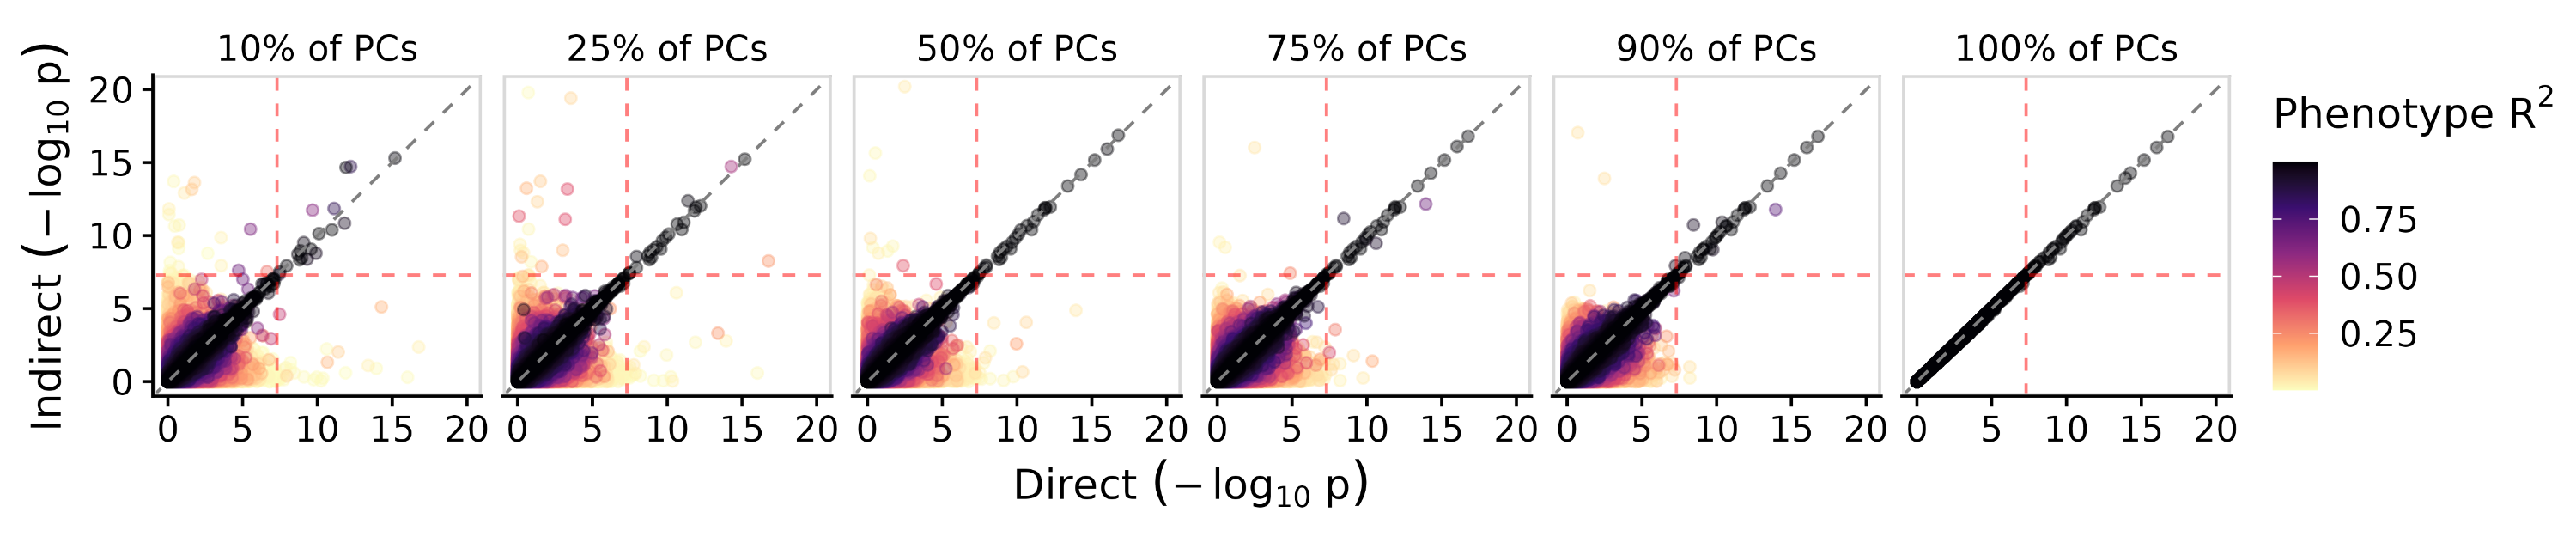

In [5]:
options(repr.plot.width = 12, repr.plot.height = 2.5, repr.plot.res = 250)

scatter <- plot_df %>%
    arrange(r2) %>%
    ggplot(aes(x = p_value_direct, y = p_value, color = r2)) +
    geom_point(alpha = 0.4) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_vline(xintercept = -log10(5e-8), linetype = "dashed", color = "red", alpha = 0.5) +
    geom_hline(yintercept = -log10(5e-8), linetype = "dashed", color = "red", alpha = 0.5) +
    facet_wrap(vars(label), nrow = 1) +
    theme_cowplot() + 
    theme(
        strip.background = element_blank()
    ) +
    panel_border() +
    xlab(expression("Direct"~(-log[10]~"p"))) +
    ylab(expression("Indirect"~(-log[10]~"p"))) +
    scale_color_viridis_c(name = expression("Phenotype"~R^2), option = "magma", direction = -1) +
    coord_cartesian(xlim = c(0, 20), ylim = c(0, 20))

save_plot("img/pca_pvalues.png", scatter, base_width = 12, base_height = 2.5, dpi = 400)

grid::grid.raster(png::readPNG("img/pca_pvalues.png"))

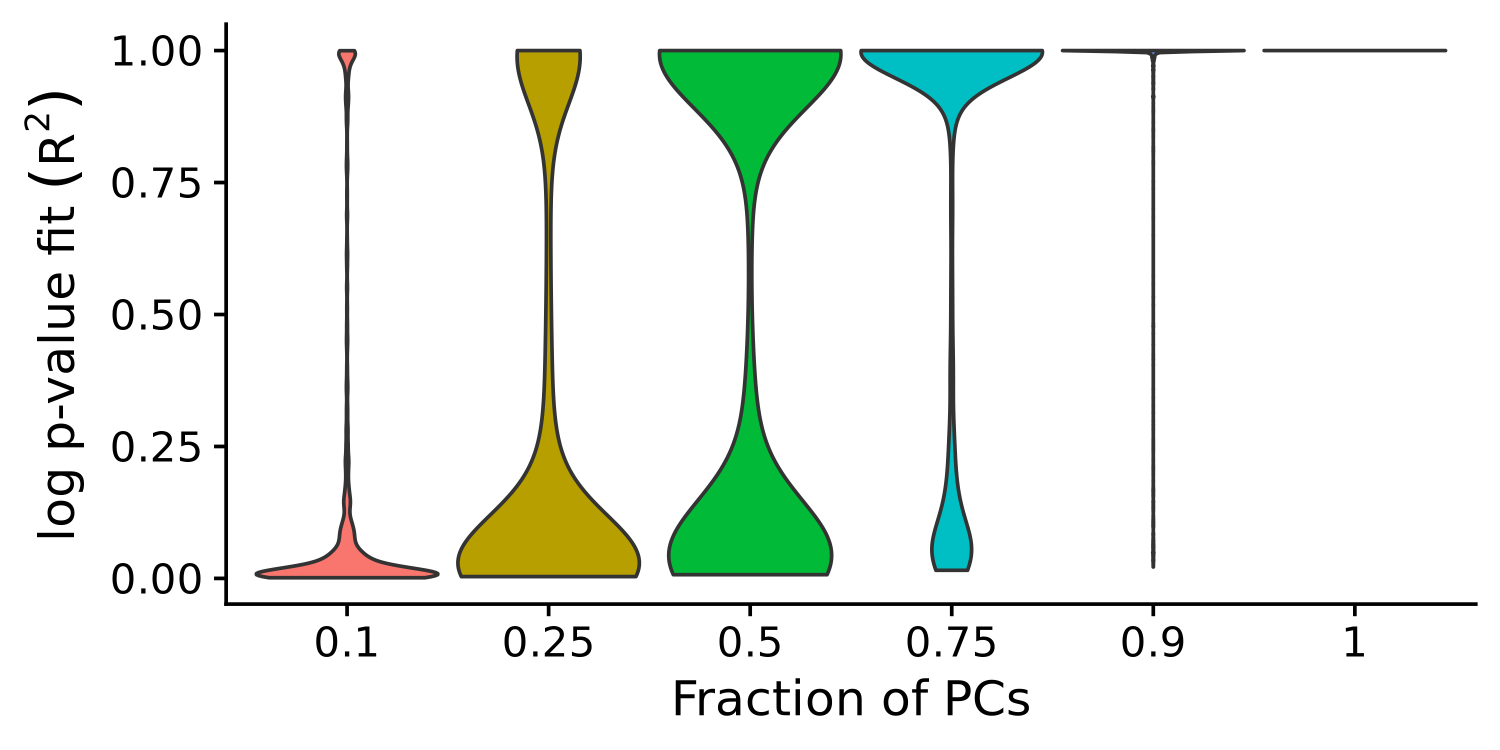

In [6]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

fit_quality_df %>%
    ggplot(aes(x = factor(fraction), y = r2, group = factor(fraction), fill = factor(fraction))) +
    geom_violin(scale = "width") +
    theme_cowplot() +
    theme(legend.position = "none") +
    xlab("Fraction of PCs") +
    ylab(expression("log p-value fit"~(R^2)))

# Evaluation plots

## Phenotype fit vs GWAS fit

In [7]:
summary_df <- plot_df %>%
    rename(pheno_r2 = r2) %>%
    group_by(phenotype_id, fraction, label, pheno_r2) %>%
    summarize(
        pvalue_r2 = rsq_vec(p_value_direct, p_value),
        .groups = "drop"
    )

summary_df %>% write_parquet("plot_data/pheno_vs_pvalue_summary.parquet")

summary_df %>% head(2)

phenotype_id,fraction,label,pheno_r2,pvalue_r2
<chr>,<dbl>,<fct>,<dbl>,<dbl>
b_A01,0.10,10% of PCs,0.001500541,8.894266e-06
b_A01,0.25,25% of PCs,0.003720120,7.508476e-05


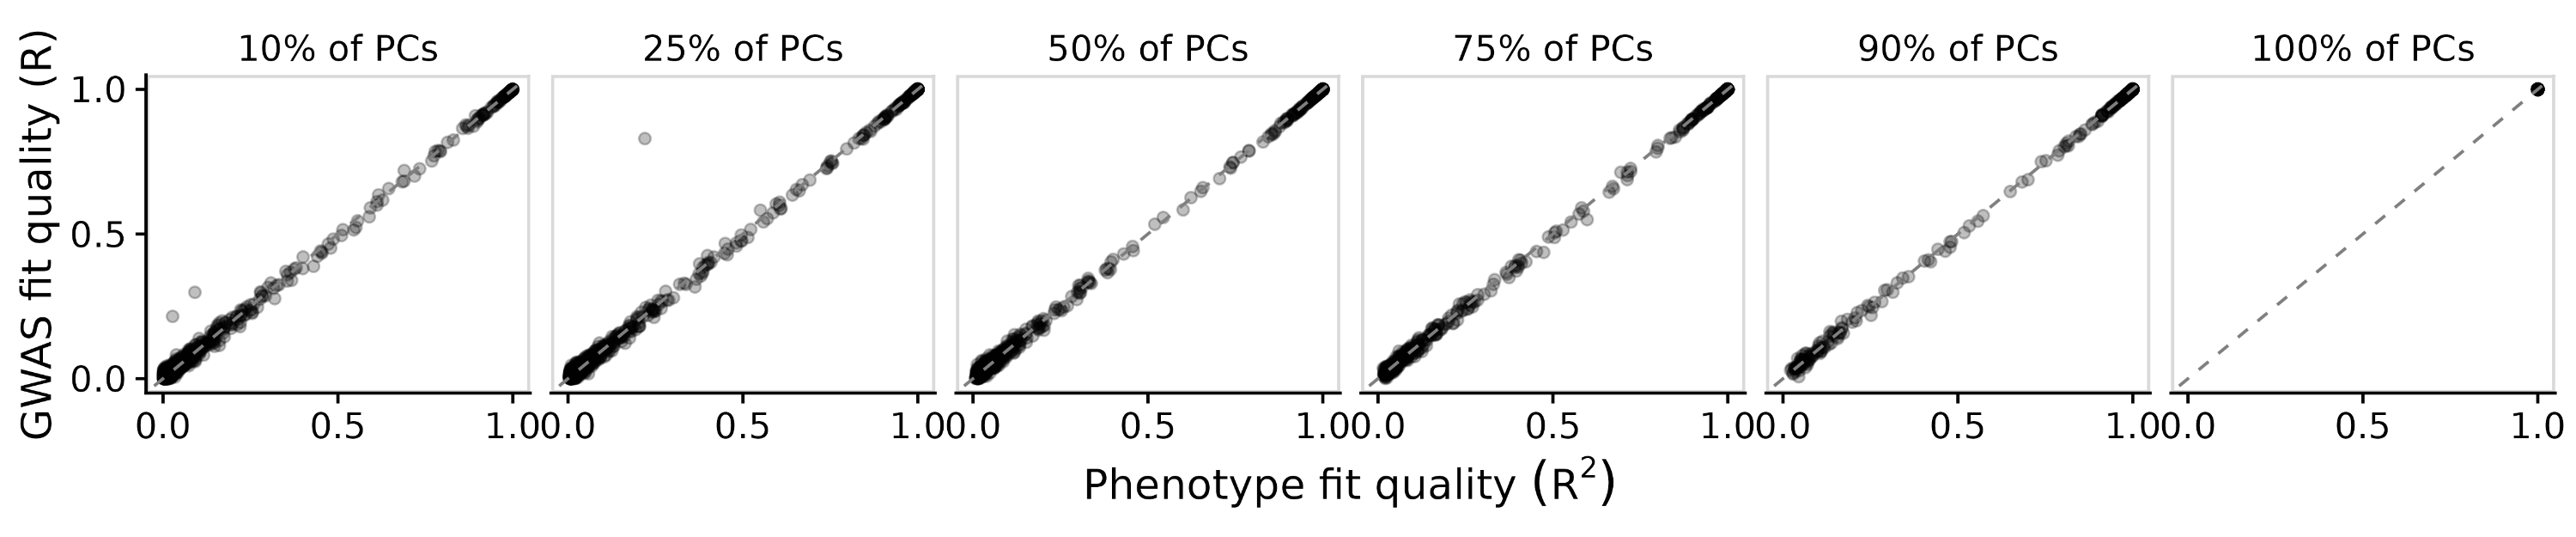

In [8]:
options(repr.plot.width = 12, repr.plot.height = 2.5, repr.plot.res = 250)

summary_plot <- summary_df %>%
    ggplot(aes(x = pheno_r2, y = sqrt(pvalue_r2))) +
    geom_point(alpha = 0.25) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    facet_wrap(vars(label), nrow = 1) +
    theme_cowplot() + 
    theme(
        strip.background = element_blank()
    ) +
    panel_border() +
    xlab(expression("Phenotype fit quality"~(R^2))) +
    ylab("GWAS fit quality (R)") +
    scale_x_continuous(n.breaks = 3) +
    scale_y_continuous(n.breaks = 3)

save_plot("img/pheno_vs_pvalue.png", summary_plot, base_width = 12, base_height = 2.5, dpi = 400)

grid::grid.raster(png::readPNG("img/pheno_vs_pvalue.png"))

## GWAS fit quality across categories

https://www.icd10data.com/ICD10CM/Codes

In [9]:
icd_category_df <- "A00-B99  Certain infectious and parasitic diseases
C00-D49  Neoplasms
D50-D89  Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
E00-E89  Endocrine, nutritional and metabolic diseases
F01-F99  Mental, Behavioral and Neurodevelopmental disorders
G00-G99  Diseases of the nervous system
H00-H59  Diseases of the eye and adnexa
H60-H95  Diseases of the ear and mastoid process
I00-I99  Diseases of the circulatory system
J00-J99  Diseases of the respiratory system
K00-K95  Diseases of the digestive system
L00-L99  Diseases of the skin and subcutaneous tissue
M00-M99  Diseases of the musculoskeletal system and connective tissue
N00-N99  Diseases of the genitourinary system
O00-O9A  Pregnancy, childbirth and the puerperium
P00-P96  Certain conditions originating in the perinatal period
Q00-Q99  Congenital malformations, deformations and chromosomal abnormalities
R00-R99  Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
S00-T88  Injury, poisoning and certain other consequences of external causes
U00-U85  Codes for special purposes
V00-Y99  External causes of morbidity
Z00-Z99  Factors influencing health status and contact with health services" %>%
    str_split("\n") %>%
    {tibble(name = .)} %>%
    unchop(name) %>%
    mutate(
        code = name %>% str_extract("^([A-Z0-9\\-]+)(?= )"),
        name = name %>% str_extract("(?<=^[A-Z0-9\\-]{7}\ )(.+)$"),
    )

icd_category_df %>% head(2)

name,code
<chr>,<chr>
Certain infectious and parasitic diseases,A00-B99
Neoplasms,C00-D49


In [10]:
category_summary_df <- icd_category_df %>%
    mutate(code = code %>% str_split("-") %>% map(~set_names(., c("start_code", "stop_code")))) %>%
    unnest_wider(code) %>%
    inner_join(
        summary_df %>%
            mutate(phenotype_id = phenotype_id %>% str_remove("b_")), 
        join_by(start_code <= phenotype_id, stop_code >= phenotype_id)
    )

category_summary_df %>% head(2)

name,start_code,stop_code,phenotype_id,fraction,label,pheno_r2,pvalue_r2
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>
Certain infectious and parasitic diseases,A00,B99,A01,0.10,10% of PCs,0.001500541,8.894266e-06
Certain infectious and parasitic diseases,A00,B99,A01,0.25,25% of PCs,0.003720120,7.508476e-05


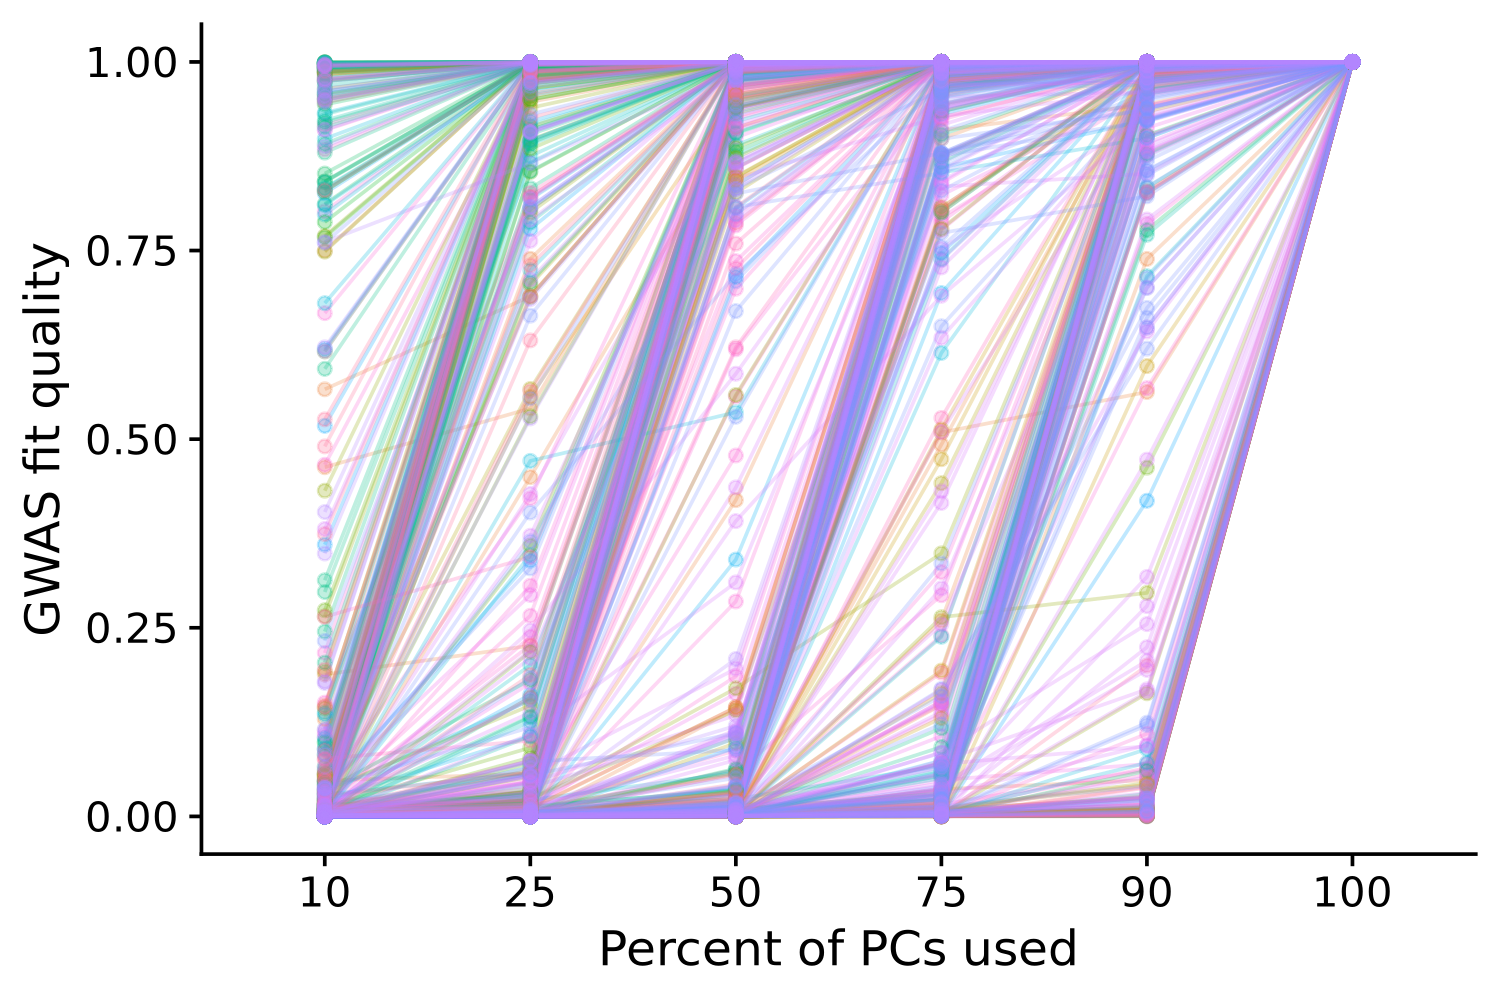

In [11]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 250)

category_summary_df %>%
    ggplot(aes(x = factor(100 * fraction), y = pvalue_r2, group = phenotype_id, color = name)) +
    geom_line(alpha = 0.25) +
    geom_point(alpha = 0.25) +
    theme_cowplot() +
    theme(
        legend.position = "none"
    ) +
    xlab("Percent of PCs used") +
    ylab("GWAS fit quality")

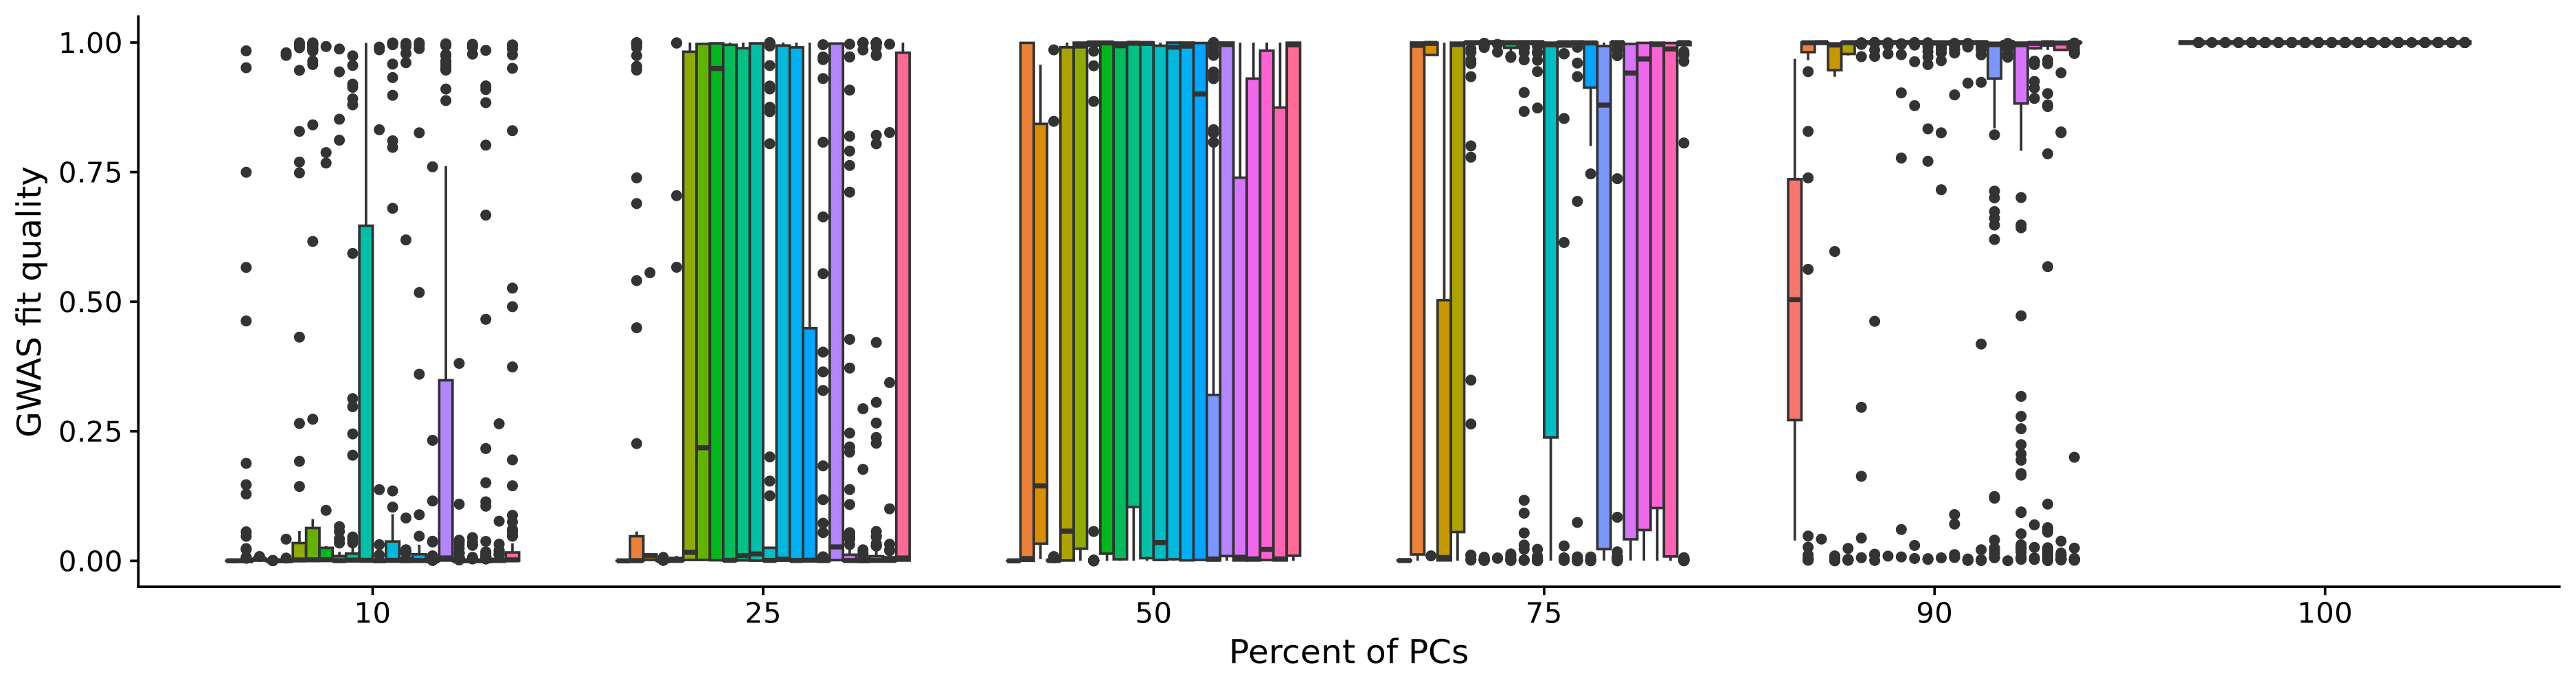

In [12]:
options(repr.plot.width = 15, repr.plot.height = 4, repr.plot.res = 250)

category_summary_df %>%
    ggplot(aes(x = factor(100 * fraction), y = pvalue_r2, group = interaction(name, fraction), fill = name)) +
    geom_boxplot(position = position_dodge()) +
    theme_cowplot() +
    theme(
        legend.position = "none"
    ) +
    xlab("Percent of PCs") +
    ylab("GWAS fit quality")

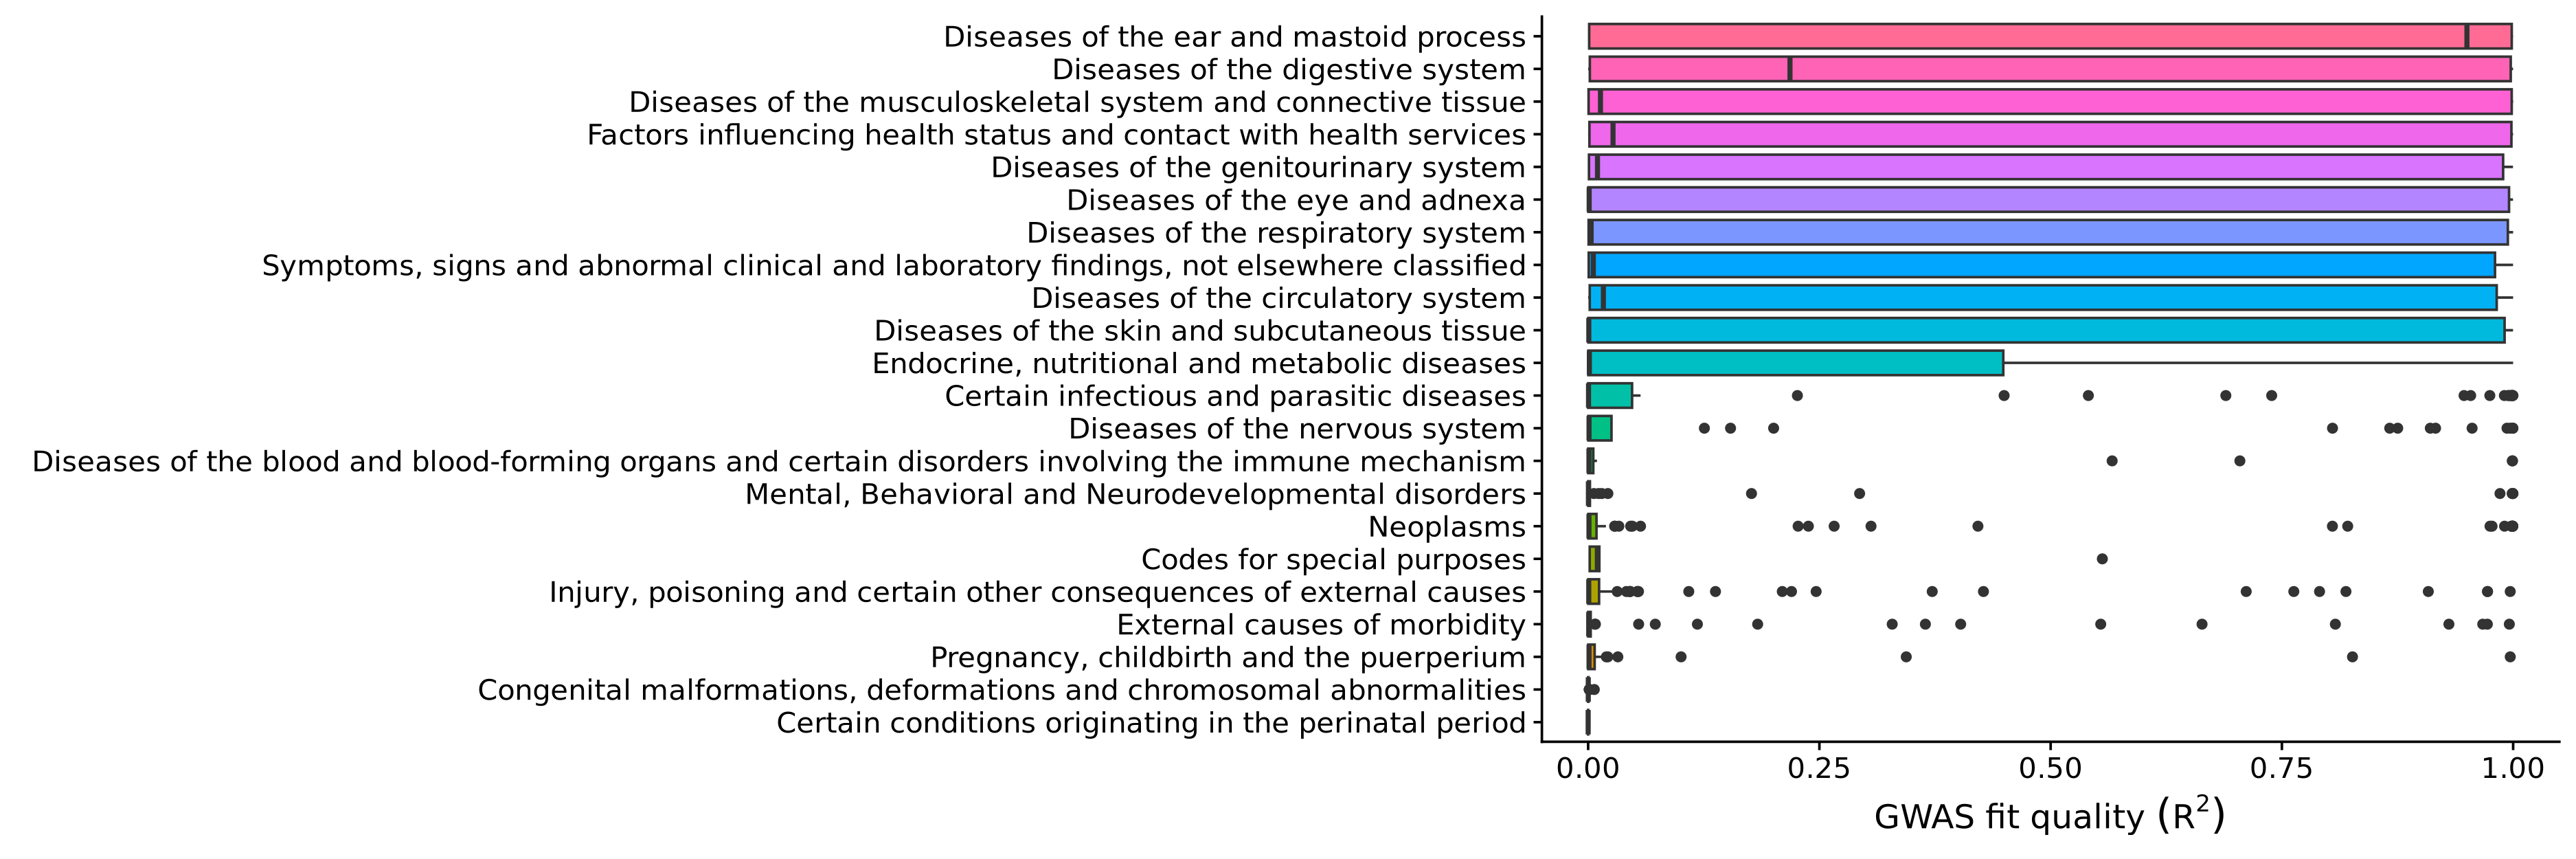

In [13]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 250)

category_summary_df %>%
    select(phenotype_id, fraction, label, pheno_r2, pvalue_r2, category_name = name) %>%
    filter(fraction == 0.25) %>%
    group_by(category_name) %>%
    mutate(mean = mean(pvalue_r2)) %>%
    ungroup %>%
    mutate(category_name = fct_reorder(category_name, mean)) %>%
    ggplot(aes(y = category_name, x = pvalue_r2, fill = category_name)) +
    geom_boxplot() +
    theme_cowplot() +
    theme(
        axis.title.y = element_blank(),
        legend.position = "none",
    ) +
    xlab(expression("GWAS fit quality"~(R^2)))